In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pickle

In [ ]:
df = pd.read_csv("winequality-red.csv")

In [ ]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [ ]:
print(df.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df["total acidity"] = df["fixed acidity"] + df["volatile acidity"]
df["acid sugar ratio"] = df["fixed acidity"] / (df["residual sugar"] + 1e-6)
df["density_alcohol_ratio"] = df["density"] / (df["alcohol"] + 1e-6)
df["sulphate_effect"] = df["sulphates"] * df["alcohol"]

In [ ]:
df["sulfur_ratio"] = df["free sulfur dioxide"] / (df["total sulfur dioxide"] + 1e-6)
df["acidity_balance"] = df["fixed acidity"] / (df["volatile acidity"] + 1e-6)
df["alcohol_volatile_interaction"] = df["alcohol"] * df["volatile acidity"]
df["log_residual_sugar"] = np.log1p(df["residual sugar"])

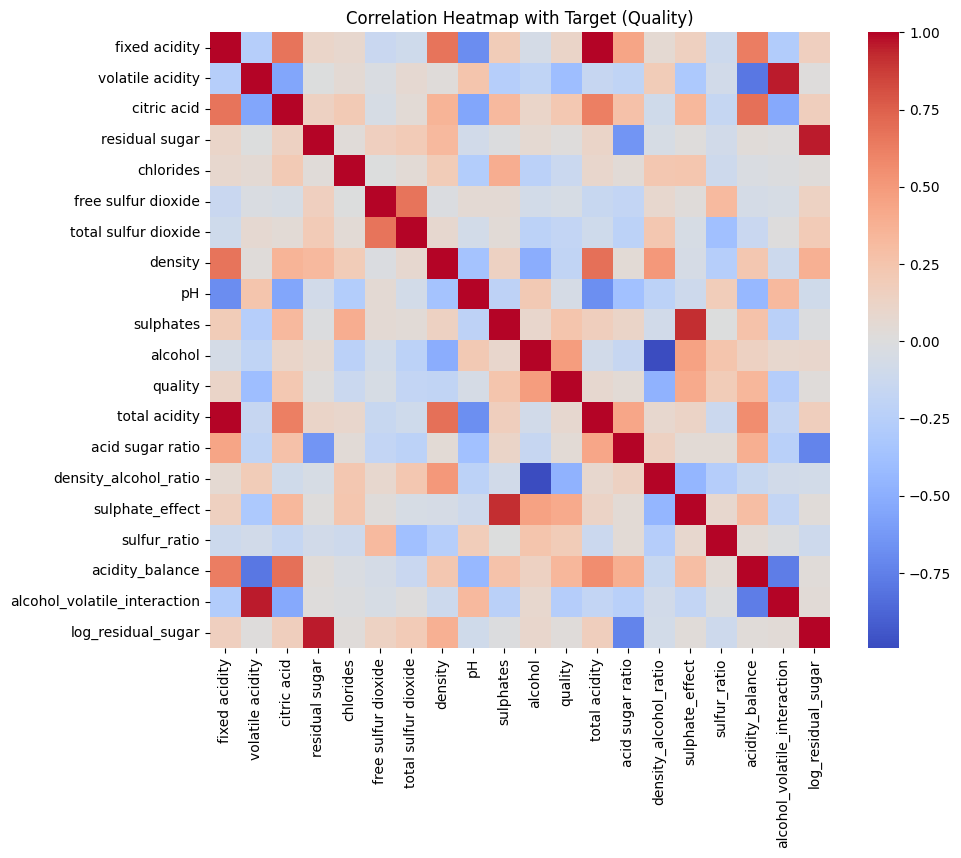

In [ ]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap with Target (Quality)")
plt.show()

In [ ]:
X = df.drop("quality", axis=1)
y = df["quality"]

In [ ]:
print("\nCross-validation R² scores:")
models_cv = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(max_depth=15, random_state=42),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(
        n_estimators=200, learning_rate=0.1, random_state=42
    ),
}

for name, model in models_cv.items():
    scores = cross_val_score(model, X, y, cv=5, scoring="r2")
    print(f"{name}: Mean CV R² -> {scores.mean():.4f}")


Cross-validation R² scores:
Linear Regression: Mean CV R² -> 0.2965
Decision Tree Regressor: Mean CV R² -> -0.2546
Random Forest Regressor: Mean CV R² -> 0.3257
Gradient Boosting Regressor: Mean CV R² -> 0.3001


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(max_depth=15, random_state=42),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(
        n_estimators=200, learning_rate=0.1, random_state=42
    )}

In [ ]:
for name, model in models.items():

    if name == "Linear Regression":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"{name}: RMSE -> {rmse:.4f}, R² -> {r2:.4f}, MAE -> {mae:.4f}")

Linear Regression: RMSE -> 0.6461, R² -> 0.3832, MAE -> 0.4918
Decision Tree Regressor: RMSE -> 0.8864, R² -> -0.1609, MAE -> 0.6179
Random Forest Regressor: RMSE -> 0.6162, R² -> 0.4390, MAE -> 0.4716
Gradient Boosting Regressor: RMSE -> 0.6298, R² -> 0.4139, MAE -> 0.4891


In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42
    )}

In [ ]:
for name, model in models.items():

    if name == "Linear Regression":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"{name}: RMSE -> {rmse:.4f}, R² -> {r2:.4f}, MAE -> {mae:.4f}")

Linear Regression: RMSE -> 0.6461, R² -> 0.3832, MAE -> 0.4918
Decision Tree Regressor: RMSE -> 0.8993, R² -> -0.1952, MAE -> 0.6275
Random Forest Regressor: RMSE -> 0.6196, R² -> 0.4328, MAE -> 0.4764
Gradient Boosting Regressor: RMSE -> 0.6218, R² -> 0.4287, MAE -> 0.4813


In [ ]:
param_dist = {
    "n_estimators": [200, 400, 600],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
}

In [ ]:
rf = RandomForestRegressor(random_state=42)

In [ ]:
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [ ]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'max_depth': [10, 20, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,n_iter,30
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [ ]:
print("\nBest Parameters found:", random_search.best_params_)


Best Parameters found: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 30}


In [ ]:
print("Best Cross-Validation R²:", random_search.best_score_)

Best Cross-Validation R²: 0.36308648804217725


In [ ]:
best_rf = random_search.best_estimator_

In [ ]:
y_pred_tuned = best_rf.predict(X_test)

In [ ]:
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)

In [ ]:
print("\nTuned Random Forest Test RMSE:", rmse_tuned)
print("Tuned Random Forest Test R²:", r2_tuned)
print("Tuned Random Forest Test MAE:", mae_tuned)


Tuned Random Forest Test RMSE: 0.6104271929501336
Tuned Random Forest Test R²: 0.4493982360277222
Tuned Random Forest Test MAE: 0.4689075773938575


In [ ]:
importances = best_rf.feature_importances_

In [ ]:
feature_names = X.columns


Top 10 Important Features:
 density_alcohol_ratio           0.140716
sulphate_effect                 0.139665
alcohol                         0.089085
sulphates                       0.072667
acidity_balance                 0.068801
volatile acidity                0.066077
total sulfur dioxide            0.047683
alcohol_volatile_interaction    0.045516
density                         0.041503
chlorides                       0.039699
dtype: float64


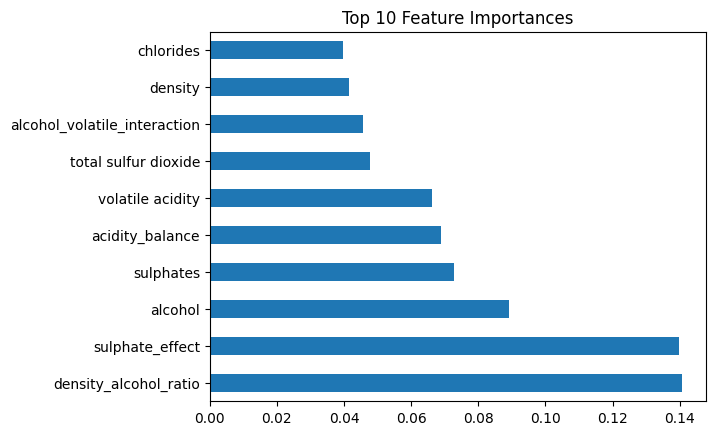

In [ ]:
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("\nTop 10 Important Features:\n", feat_imp.head(10))

feat_imp.head(10).plot(kind="barh", title="Top 10 Feature Importances")
plt.show()

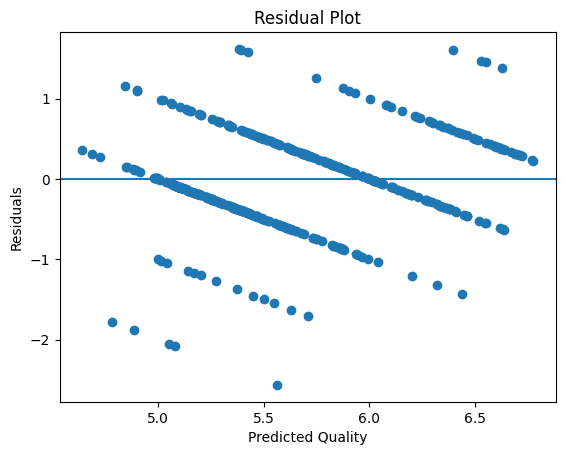

In [ ]:
residuals = y_test - y_pred_tuned

plt.scatter(y_pred_tuned, residuals)
plt.axhline(0)
plt.xlabel("Predicted Quality")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [ ]:
with open("best_wine_quality_model.pkl", "wb") as file:
    pickle.dump(best_rf, file)

In [ ]:
with open("scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)